In [ ]:
#%%

import torch
import torch.nn as nn
import torch.nn.functional as F

# basic block of resnet18 style cnn 
class BasicBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        # skip connection
        out += identity  
        return F.relu(out)

In [ ]:
# %%

class MiniResNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # stacked residual blocks to make a mini resnet18(simplified)
        self.layer1 = self._make_layer(64, num_blocks=2)
        self.layer2 = self._make_layer(64, num_blocks=2)
        self.layer3 = self._make_layer(64, num_blocks=2)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, channels, num_blocks):
        layers = []
        for _ in range(num_blocks):
            layers.append(BasicBlock(channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [ ]:
# %%

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize RGB channels
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# %%

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MiniResNet().to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# %%

for epoch in range(5):  # Train for 5 epochs
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1, Loss: 1.2979
Epoch 2, Loss: 0.9324
Epoch 3, Loss: 0.7705
Epoch 4, Loss: 0.6502
Epoch 5, Loss: 0.5708


In [ ]:
# %%

model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 75.83%


In [ ]:
# %%

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def show_filters(model):
    first_conv = model.stem[0]  # nn.Conv2d(3, 64, ...)
    filters = first_conv.weight.data.clone().cpu()

    # Normalize to [0,1] for visualization
    filters = (filters - filters.min()) / (filters.max() - filters.min())

    grid = make_grid(filters, nrow=8, padding=1)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0))  # CHW → HWC
    plt.axis('off')
    plt.title("MiniResNet First Layer Filters")
    plt.show()

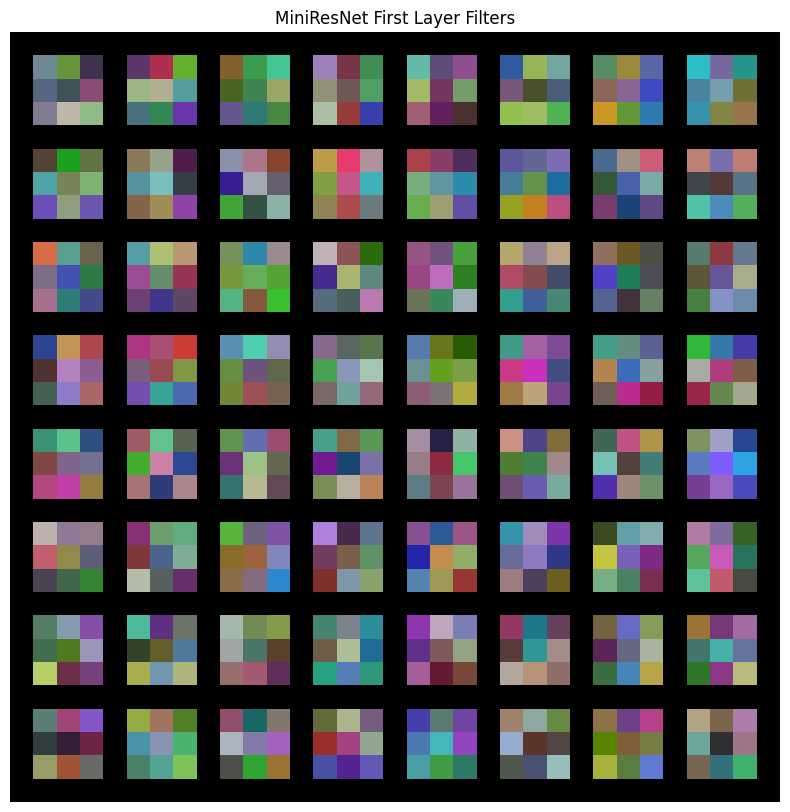

In [ ]:
# %%

show_filters(model)